In [123]:
import pickle as pkl
import pandas as pd
import numpy as np

from IPython.display import clear_output

%run utils/utils_metrics.py

### Load data

In [2]:
output_scaler = pkl.load(open('../features_extracted/scalers/out_scaler.scl', 'rb'))
dataset = pkl.load(open('../features_extracted/taxi_trip_data_normalized_10M.dat', 'rb'))
dataset.head()

,pu_lon,pu_lat,do_lon,do_lat,vec_dist,grid_trip_dist,avg_hour_sin,avg_hour_cos,week_day_sin,week_day_cos,duration
0,-0.618153,0.438220,1.350339,3.926724,2.505878,1.943777,-0.866025,5.000000e-01,0.781831,0.623490,0.148974
1,-0.571665,-0.016438,-0.551556,-0.526279,-0.443558,-0.434851,0.500000,-8.660254e-01,0.433884,-0.900969,0.822718
2,0.022083,0.039781,-0.233493,0.183234,-0.648665,-0.619845,-0.500000,-8.660254e-01,-0.781831,0.623490,-0.503036
3,-0.491446,-0.228516,-0.339226,-0.690281,-0.467870,-0.452716,-0.500000,8.660254e-01,0.433884,-0.900969,-0.750465
4,-0.537286,-0.348061,-0.057487,-0.095531,-0.448858,-0.441419,-1.000000,-1.836970e-16,-0.974928,-0.222521,-0.146938


In [7]:
dataset['denorm_duration'] = output_scaler.inverse_transform(dataset.duration)
dataset.drop(dataset[dataset.denorm_duration == 0].index, inplace=True)
dataset.reset_index(inplace=True)
dataset.drop('index', axis=1, inplace=True)
dataset.drop('denorm_duration', axis=1, inplace=True)
dataset.shape

(9999848, 11)

### Splitting data

In [25]:
n_feats = dataset.shape[1] - 1

train_p = 0.7
valid_p = 0.2

train_data, validation_data, test_data = np.split(dataset.sample(frac=1, random_state=2112), 
                                              [int(train_p * len(dataset)), 
                                               int((train_p + valid_p) * len(dataset))])
# Train data
X_train = train_data[train_data.columns[:-1]]
y_train = train_data[train_data.columns[-1]]

# Validation data
X_valid = validation_data[validation_data.columns[:-1]]
y_valid = validation_data[validation_data.columns[-1]]

# Testing data
X_test = test_data[test_data.columns[:-1]]
y_test = test_data[test_data.columns[-1]]
y_test_denorm = output_scaler.inverse_transform(y_test).reshape(-1,1)

print('Train/Valid/Test = {0} / {1} / {2}'.format(len(train_data), len(validation_data), len(test_data)))

Train/Valid/Test = 6999893 / 1999970 / 999985


### Build model

In [148]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

In [164]:
import tensorflow as tf

def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)

In [170]:
def build_model():
    
    model = Sequential()
    
    model.add(Dense(200, activation  = tf.nn.relu, input_shape = (n_feats,)))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    opt = optimizers.Adam(lr=0.001)

    model.compile(loss=huber_loss,
                  optimizer=opt,
                  metrics=['mae'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 200)               2200      
_________________________________________________________________
dense_80 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_81 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_82 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_83 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_84 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_85 (Dense)             (None, 50)                2550      
__________

### 5. Training

In [171]:
EPOCHS = 25*2
BATCH_SIZE = 64

tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

# Store training stats
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    callbacks=[tensorboard]
                   )
                    #, callbacks=[PrintDot()])

Train on 6999893 samples, validate on 1999970 samples
Epoch 1/50
6999893/6999893 [==============================] - 461s 66us/step - loss: 0.0850 - mean_absolute_error: 0.2837 - val_loss: 0.0808 - val_mean_absolute_error: 0.2736
Epoch 2/50
6999893/6999893 [==============================] - 456s 65us/step - loss: 0.0804 - mean_absolute_error: 0.2740 - val_loss: 0.0799 - val_mean_absolute_error: 0.2701
Epoch 3/50
6999893/6999893 [==============================] - 435s 62us/step - loss: 0.0792 - mean_absolute_error: 0.2714 - val_loss: 0.0786 - val_mean_absolute_error: 0.2708
Epoch 4/50
6999893/6999893 [==============================] - 435s 62us/step - loss: 0.0785 - mean_absolute_error: 0.2699 - val_loss: 0.0780 - val_mean_absolute_error: 0.2705
Epoch 5/50
6999893/6999893 [==============================] - 435s 62us/step - loss: 0.0780 - mean_absolute_error: 0.2687 - val_loss: 0.0775 - val_mean_absolute_error: 0.2677
Epoch 6/50
6999893/6999893 [==============================] - 435s 62us

In [151]:
EPOCHS = 25
BATCH_SIZE = 64

tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

# Store training stats
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    callbacks=[tensorboard]
                   )
                    #, callbacks=[PrintDot()])

Train on 6999893 samples, validate on 1999970 samples
Epoch 1/25
6999893/6999893 [==============================] - 363s 52us/step - loss: 0.2084 - mean_absolute_error: 0.2905 - val_loss: 0.1990 - val_mean_absolute_error: 0.2858
Epoch 2/25
6999893/6999893 [==============================] - 366s 52us/step - loss: 0.1973 - mean_absolute_error: 0.2810 - val_loss: 0.1962 - val_mean_absolute_error: 0.2740
Epoch 3/25
6999893/6999893 [==============================] - 365s 52us/step - loss: 0.1946 - mean_absolute_error: 0.2785 - val_loss: 0.1931 - val_mean_absolute_error: 0.2798
Epoch 4/25
6999893/6999893 [==============================] - 363s 52us/step - loss: 0.1929 - mean_absolute_error: 0.2770 - val_loss: 0.1939 - val_mean_absolute_error: 0.2766
Epoch 5/25
6999893/6999893 [==============================] - 363s 52us/step - loss: 0.1918 - mean_absolute_error: 0.2760 - val_loss: 0.1910 - val_mean_absolute_error: 0.2774
Epoch 6/25
6999893/6999893 [==============================] - 362s 52us

In [152]:
y_pred = model.predict(X_test)
y_pred_denorm = output_scaler.inverse_transform(y_pred)

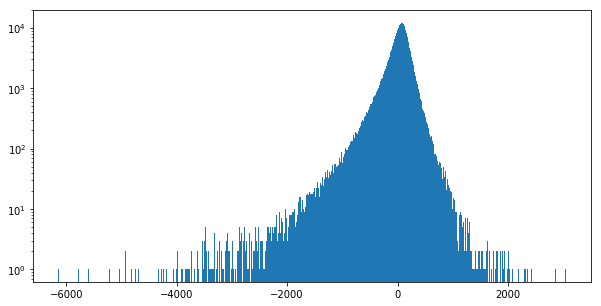

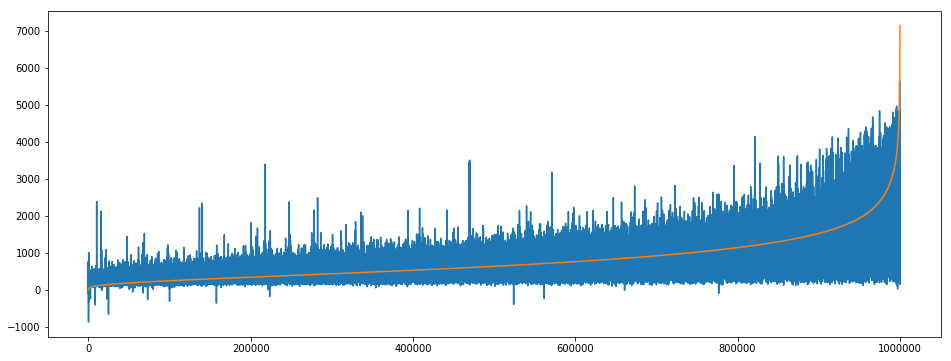

In [154]:
import matplotlib.pyplot as plt

index_y_test = np.argsort(y_test_denorm,axis=0)

plt.figure(figsize=(10,5))
plt.hist(y_pred_denorm - y_test_denorm, bins='auto',log=True)
plt.show()

plt.figure(figsize=(16,6))
plt.plot(y_pred_denorm[index_y_test[:],:].ravel())
plt.plot(y_test_denorm[index_y_test[:],:].ravel())
plt.show()

### Computing metrics

In [155]:
y_pred_denorm_clipped = y_pred_denorm.clip(min=0)
y_pred_clipped = output_scaler.transform(y_pred_denorm_clipped) 

compute_metrics(y_true = y_test.values, 
                y_pred = y_pred_clipped,
                y_true_denorm = y_test_denorm, 
                y_pred_denorm = y_pred_denorm_clipped,
                indices=['Model'])

,Exp. Var.,RMSLE,MAPE,MdAPE,MAE,MdAE
Model,0.812342,0.328455,0.277299,0.189566,166.043888,115.432983


In [122]:
y_pred_denorm_clipped = y_pred_denorm.clip(min=0)
y_pred_clipped = output_scaler.transform(y_pred_denorm_clipped) 

compute_metrics(y_true = y_test.values, 
                y_pred = y_pred_clipped,
                y_true_denorm = y_test_denorm, 
                y_pred_denorm = y_pred_denorm_clipped,
                indices=['Model'])

,Exp. Var.,RMSLE,MAPE,MdAPE,MAE,MdAE
Model,0.80691,0.331294,0.275276,0.186238,166.647117,113.17276
